In [16]:
# -*- coding: utf-8 -*-
# The provided metrics from the authors github repository
"""
Evaluation metrics

Author: G.J.J. van den Burg
Copyright (c) 2020 - The Alan Turing Institute
License: See the LICENSE file.

"""


def true_positives(T, X, margin=5):
    """Compute true positives without double counting

    >>> true_positives({1, 10, 20, 23}, {3, 8, 20})
    {1, 10, 20}
    >>> true_positives({1, 10, 20, 23}, {1, 3, 8, 20})
    {1, 10, 20}
    >>> true_positives({1, 10, 20, 23}, {1, 3, 5, 8, 20})
    {1, 10, 20}
    >>> true_positives(set(), {1, 2, 3})
    set()
    >>> true_positives({1, 2, 3}, set())
    set()
    """
    # make a copy so we don't affect the caller
    X = set(list(X))
    TP = set()
    for tau in T:
        close = [(abs(tau - x), x) for x in X if abs(tau - x) <= margin]
        close.sort()
        if not close:
            continue
        dist, xstar = close[0]
        TP.add(tau)
        X.remove(xstar)
    return TP


def f_measure(annotations, predictions, margin=5, alpha=0.5, return_PR=False):
    """Compute the F-measure based on human annotations.

    annotations : dict from user_id to iterable of CP locations
    predictions : iterable of predicted CP locations
    alpha : value for the F-measure, alpha=0.5 gives the F1-measure
    return_PR : whether to return precision and recall too

    Remember that all CP locations are 0-based!

    >>> f_measure({1: [10, 20], 2: [11, 20], 3: [10], 4: [0, 5]}, [10, 20])
    1.0
    >>> f_measure({1: [], 2: [10], 3: [50]}, [10])
    0.9090909090909091
    >>> f_measure({1: [], 2: [10], 3: [50]}, [])
    0.8
    """
    # ensure 0 is in all the sets
    Tks = {k + 1: set(annotations[uid]) for k, uid in enumerate(annotations)}
    for Tk in Tks.values():
        Tk.add(0)

    X = set(predictions)
    X.add(0)

    Tstar = set()
    for Tk in Tks.values():
        for tau in Tk:
            Tstar.add(tau)

    K = len(Tks)

    P = len(true_positives(Tstar, X, margin=margin)) / len(X)

    TPk = {k: true_positives(Tks[k], X, margin=margin) for k in Tks}
    R = 1 / K * sum(len(TPk[k]) / len(Tks[k]) for k in Tks)

    F = P * R / (alpha * R + (1 - alpha) * P)
    if return_PR:
        return F, P, R
    return F


def overlap(A, B):
    """Return the overlap (i.e. Jaccard index) of two sets

    >>> overlap({1, 2, 3}, set())
    0.0
    >>> overlap({1, 2, 3}, {2, 5})
    0.25
    >>> overlap(set(), {1, 2, 3})
    0.0
    >>> overlap({1, 2, 3}, {1, 2, 3})
    1.0
    """
    return len(A.intersection(B)) / len(A.union(B))


def partition_from_cps(locations, n_obs):
    """Return a list of sets that give a partition of the set [0, T-1], as
    defined by the change point locations.

    >>> partition_from_cps([], 5)
    [{0, 1, 2, 3, 4}]
    >>> partition_from_cps([3, 5], 8)
    [{0, 1, 2}, {3, 4}, {5, 6, 7}]
    >>> partition_from_cps([1,2,7], 8)
    [{0}, {1}, {2, 3, 4, 5, 6}, {7}]
    >>> partition_from_cps([0, 4], 6)
    [{0, 1, 2, 3}, {4, 5}]
    """
    T = n_obs
    partition = []
    current = set()

    all_cps = iter(sorted(set(locations)))
    cp = next(all_cps, None)
    for i in range(T):
        if i == cp:
            if current:
                partition.append(current)
            current = set()
            cp = next(all_cps, None)
        current.add(i)
    partition.append(current)
    return partition


def cover_single(S, Sprime):
    """Compute the covering of a segmentation S by a segmentation Sprime.

    This follows equation (8) in Arbaleaz, 2010.

    >>> cover_single([{1, 2, 3}, {4, 5, 6}], [{1, 2, 3}, {4, 5}, {6}])
    0.8333333333333334
    >>> cover_single([{1, 2, 3, 4, 5, 6}], [{1, 2, 3, 4}, {5, 6}])
    0.6666666666666666
    >>> cover_single([{1, 2, 3}, {4, 5, 6}], [{1, 2}, {3, 4}, {5, 6}])
    0.6666666666666666
    >>> cover_single([{1}, {2}, {3}, {4, 5, 6}], [{1, 2, 3, 4, 5, 6}])
    0.3333333333333333
    """
    T = sum(map(len, Sprime))
    assert T == sum(map(len, S))
    C = 0
    for R in S:
        C += len(R) * max(overlap(R, Rprime) for Rprime in Sprime)
    C /= T
    return C


def covering(annotations, predictions, n_obs):
    """Compute the average segmentation covering against the human annotations.

    annotations : dict from user_id to iterable of CP locations
    predictions : iterable of predicted Cp locations
    n_obs : number of observations in the series

    >>> covering({1: [10, 20], 2: [10], 3: [0, 5]}, [10, 20], 45)
    0.7962962962962963
    >>> covering({1: [], 2: [10], 3: [40]}, [10], 45)
    0.7954144620811286
    >>> covering({1: [], 2: [10], 3: [40]}, [], 45)
    0.8189300411522634

    """
    Ak = {
        k + 1: partition_from_cps(annotations[uid], n_obs)
        for k, uid in enumerate(annotations)
    }
    pX = partition_from_cps(predictions, n_obs)

    Cs = [cover_single(Ak[k], pX) for k in Ak]
    return sum(Cs) / len(Cs)


In [71]:
annotations = {
    "bitcoin": {
        6: [502, 580, 702, 747],
        8: [583],
        12: [597],
        13: [522, 579, 591, 629, 703, 747, 760],
        14: [93, 522, 540, 701, 747, 760, 772]
    },
    "nile": {
        6: [],
        7: [28],
        8: [],
        12: [28],
        13: [28]
    },
    "quality_control_1": {
        6: [143],
        7: [144],
        8: [144],
        9: [146],
        12: [144]
    },
    "unemployment_nl": {
		"6": [
			54,
			116,
			130,
			132,
			143,
			171,
			180
		],
		"8": [
			182
		],
		"10": [
			131,
			144,
			181
		],
		"12": [],
		"13": [
			54,
			77,
			114,
			131,
			138,
			143,
			171,
			176,
			180
		]
	},
    "well_log": {
		"6": [
			179,
			255,
			281,
			311,
			343,
			402,
			413,
			422,
			432,
			462,
			464
		],
		"7": [
			179,
			255,
			281,
			312,
			343,
			402,
			412,
			422,
			432
		],
		"8": [
			179,
			255,
			282,
			312,
			343,
			402,
			413,
			422,
			432
		],
		"12": [
			177,
			467
		],
		"13": [
			4,
			179,
			255,
			281,
			311,
			344,
			402,
			412,
			422,
			432,
			462,
			464,
			521,
			526,
			620,
			643,
			661
		]
	},
    "us_population": {
		"6": [],
		"7": [],
		"8": [],
		"9": [
			462
		],
		"12": [
			460
		]
	},
    "seatbelts": {
		"7": [
			61,
			169
		],
		"8": [
			60,
			169
		],
		"10": [],
		"12": [
			60,
			169
		],
		"13": [
			60,
			79,
			169
		]
	},
    "global_co2": {
		"6": [],
		"7": [
			46,
			90
		],
		"8": [],
		"9": [
			47,
			91
		],
		"13": []
	},
}

C:\Users\Relu\AppData\Local\Temp\ipykernel_17308\1322795761.py:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0].scatter(change_point, bitcoin_data[change_point], c=color, label=f"Annotator {annotator}")
C:\Users\Relu\AppData\Local\Temp\ipykernel_17308\1322795761.py:41: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[1].scatter(change_point, nile_data[change_point], c=color, label=f"Annotator {annotator}")
C:\Users\

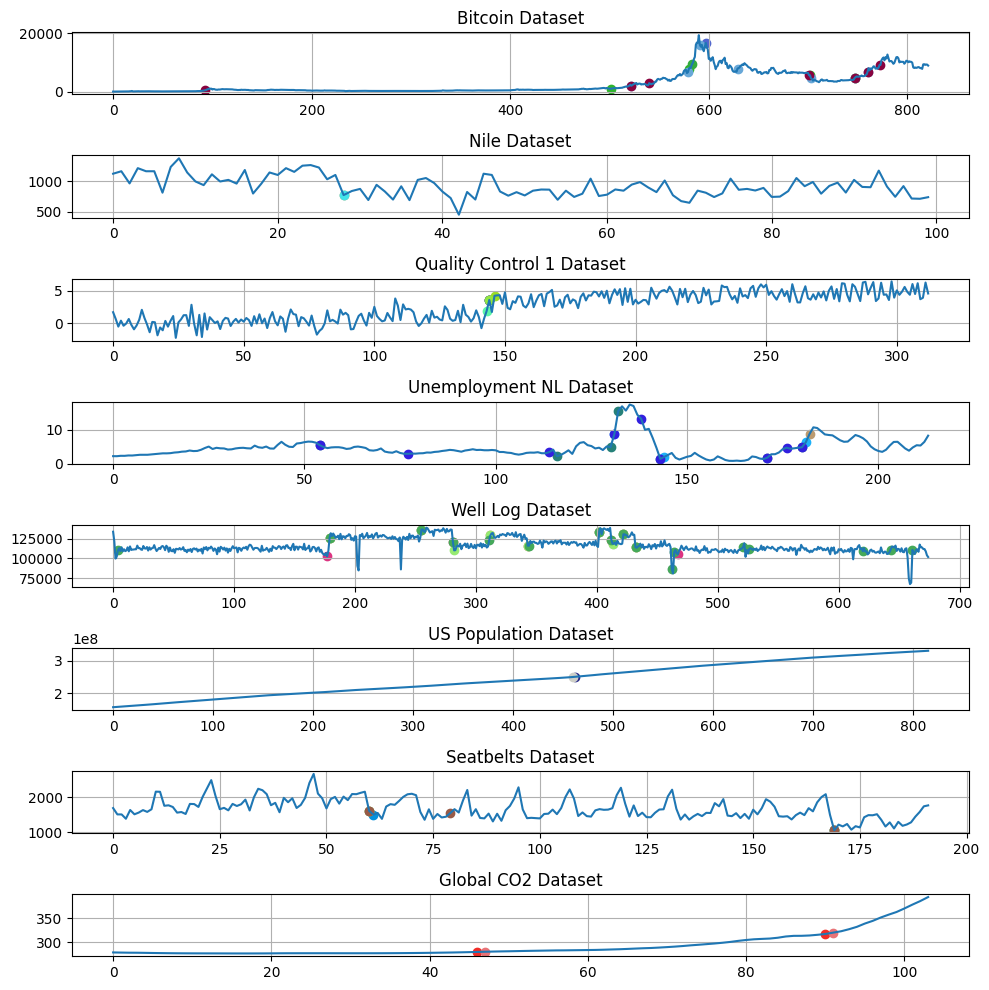

In [72]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_dataset(dataset_name):
    if dataset_name == "bitcoin":
        df = pd.read_csv("bitcoin.csv")
        data = df["value"].values  # Assuming "value" is the column name
    else:
        with open(f"{dataset_name}.json", "r") as f:
            json_data = json.load(f)
            data = np.array(json_data["series"][0]["raw"])
    return data

# Load datasets
bitcoin_data = load_dataset("bitcoin")
nile_data = load_dataset("nile")
qc1_data = load_dataset("quality_control_1")
unemployment_nl_data = load_dataset("unemployment_nl")
well_log_data = load_dataset("well_log")
us_population_data = load_dataset("us_population")
seatbelts_data = load_dataset("seatbelts")
global_co2_data = load_dataset("global_co2")

fig, axs = plt.subplots(8, 1, figsize=(10, 10))
axs[0].plot(bitcoin_data)
axs[0].set_title("Bitcoin Dataset")
axs[0].grid(True)
for annotator, change_points in annotations["bitcoin"].items():
    # generate a random color for each annotator
    color = np.random.rand(3,)
    for change_point in change_points:
        axs[0].scatter(change_point, bitcoin_data[change_point], c=color, label=f"Annotator {annotator}")
axs[1].plot(nile_data)
axs[1].set_title("Nile Dataset")
axs[1].grid(True)
for annotator, change_points in annotations["nile"].items():
    color = np.random.rand(3,)
    for change_point in change_points:
        axs[1].scatter(change_point, nile_data[change_point], c=color, label=f"Annotator {annotator}")
axs[2].plot(qc1_data)
axs[2].set_title("Quality Control 1 Dataset")
axs[2].grid(True)
for annotator, change_points in annotations["quality_control_1"].items():
    color = np.random.rand(3,)
    for change_point in change_points:
        axs[2].scatter(change_point, qc1_data[change_point], c=color, label=f"Annotator {annotator}")
axs[3].plot(unemployment_nl_data)
axs[3].set_title("Unemployment NL Dataset")
axs[3].grid(True)
for annotator, change_points in annotations["unemployment_nl"].items():
    color = np.random.rand(3,)
    for change_point in change_points:
        axs[3].scatter(change_point, unemployment_nl_data[change_point], c=color, label=f"Annotator {annotator}")
axs[4].plot(well_log_data)
axs[4].set_title("Well Log Dataset")
axs[4].grid(True)
for annotator, change_points in annotations["well_log"].items():
    color = np.random.rand(3,)
    for change_point in change_points:
        axs[4].scatter(change_point, well_log_data[change_point], c=color, label=f"Annotator {annotator}")
axs[5].plot(us_population_data)
axs[5].set_title("US Population Dataset")
axs[5].grid(True)
for annotator, change_points in annotations["us_population"].items():
    color = np.random.rand(3,)
    for change_point in change_points:
        axs[5].scatter(change_point, us_population_data[change_point], c=color, label=f"Annotator {annotator}")
axs[6].plot(seatbelts_data)
axs[6].set_title("Seatbelts Dataset")
axs[6].grid(True)
for annotator, change_points in annotations["seatbelts"].items():
    color = np.random.rand(3,)
    for change_point in change_points:
        axs[6].scatter(change_point, seatbelts_data[change_point], c=color, label=f"Annotator {annotator}")
axs[7].plot(global_co2_data)
axs[7].set_title("Global CO2 Dataset")
axs[7].grid(True)
for annotator, change_points in annotations["global_co2"].items():
    color = np.random.rand(3,)
    for change_point in change_points:
        axs[7].scatter(change_point, global_co2_data[change_point], c=color, label=f"Annotator {annotator}")

plt.tight_layout()
plt.show()




In [82]:
import ruptures as rpt

# ----------------------------------------
# Binary Segmentation (BinSeg)
# ----------------------------------------
def run_binseg_auto(data):
    sigma = np.std(data)
    sigma_sq = sigma ** 2
    
    n = len(data)
    pen = np.log(n) * sigma_sq
    
    algo = rpt.Binseg().fit(data)
    return algo.predict(pen=pen)

In [79]:
def compute_energy(data, tau):
    n = tau
    m = len(data) - tau
    term1 = (2 / (n * m)) * np.sum(np.abs(data[:tau] - data[tau:][:, np.newaxis]))
    term2 = (1 / n ** 2) * np.sum(np.abs(data[:tau] - data[:tau][:, np.newaxis]))
    term3 = (1 / m ** 2) * np.sum(np.abs(data[tau:] - data[tau:][:, np.newaxis]))
    return term1 - term2 - term3

def run_ecp(data, margin=5):
    candidates = range(margin, len(data)-margin)  # avoid edges
    scores = [compute_energy(data, tau) for tau in candidates]
    tau_star = candidates[np.argmax(scores)]
    return [tau_star]

In [87]:
def evaluate_dataset(dataset_name, data, annotations_dict):
    annotations = {k: [x for x in v if x < len(data)] for k, v in annotations_dict.items()}
    
    binseg_pred = run_binseg_auto(data)
    ecp_pred = run_ecp(data)
    
    binseg_pred = [x for x in binseg_pred if x != len(data)]
    
    print(f"\nResults for {dataset_name}:")
    print(f"BinSeg detected: {binseg_pred}")
    print(f"ECP detected: {ecp_pred}")

    f1_binseg = f_measure(annotations, binseg_pred, margin=5)
    f1_ecp = f_measure(annotations, ecp_pred, margin=5)
    cover_binseg = covering(annotations, binseg_pred, len(data))
    cover_ecp = covering(annotations, ecp_pred, len(data))

    print(f"BinSeg: F1 = {f1_binseg:.2f}, Cover = {cover_binseg:.2f}")
    print(f"ECP:    F1 = {f1_ecp:.2f}, Cover = {cover_ecp:.2f}")

    return f1_binseg, cover_binseg, f1_ecp, cover_ecp, binseg_pred, ecp_pred

In [89]:
f1_binseg_bitcoin, cover_binseg_bitcoin, f1_ecp_bitcoin, cover_ecp_bitcoin, binseg_pred_bitcoin, ecp_pred_bitcoin = evaluate_dataset("Bitcoin", bitcoin_data, annotations["bitcoin"])
f1_binseg_nile, cover_binseg_nile, f1_ecp_nile, cover_ecp_nile, binseg_pred_nile, ecp_pred_nile = evaluate_dataset("Nile", nile_data, annotations["nile"])
f1_binseg_qc1, cover_binseg_qc1, f1_ecp_qc1, cover_ecp_qc1, binseg_pred_qc1, ecp_pred_qc1 = evaluate_dataset("Quality Control 1", qc1_data, annotations["quality_control_1"])
f1_binseg_unemployment_nl, cover_binseg_unemployment_nl, f1_ecp_unemployment_nl, cover_ecp_unemployment_nl, binseg_pred_unemployment_nl, ecp_pred_unemployment_nl = evaluate_dataset("Unemployment NL", unemployment_nl_data, annotations["unemployment_nl"])
f1_binseg_well_log, cover_binseg_well_log, f1_ecp_well_log, cover_ecp_well_log, binseg_pred_well_log, ecp_pred_well_log = evaluate_dataset("Well Log", well_log_data, annotations["well_log"])
f1_binseg_us_population, cover_binseg_us_population, f1_ecp_us_population, cover_ecp_us_population, binseg_pred_us_population, ecp_pred_us_population = evaluate_dataset("US Population", us_population_data, annotations["us_population"])
f1_binseg_seatbelts, cover_binseg_seatbelts, f1_ecp_seatbelts, cover_ecp_seatbelts, binseg_pred_seatbelts, ecp_pred_seatbelts = evaluate_dataset("Seatbelts", seatbelts_data, annotations["seatbelts"])
f1_binseg_global_co2, cover_binseg_global_co2, f1_ecp_global_co2, cover_ecp_global_co2, binseg_pred_global_co2, ecp_pred_global_co2 = evaluate_dataset("Global CO2", global_co2_data, annotations["global_co2"])




Results for Bitcoin:
BinSeg detected: [515, 550, 580, 585, 605, 650, 700, 760, 770]
ECP detected: [772]
BinSeg: F1 = 0.61, Cover = 0.74
ECP:    F1 = 0.48, Cover = 0.53

Results for Nile:
BinSeg detected: [30]
ECP detected: [28]
BinSeg: F1 = 1.00, Cover = 0.86
ECP:    F1 = 1.00, Cover = 0.89

Results for Quality Control 1:
BinSeg detected: [95, 145, 180]
ECP detected: [144]
BinSeg: F1 = 0.67, Cover = 0.73
ECP:    F1 = 1.00, Cover = 1.00

Results for Unemployment NL:
BinSeg detected: [130, 140, 145, 180, 195]
ECP detected: [5]
BinSeg: F1 = 0.82, Cover = 0.62
ECP:    F1 = 0.44, Cover = 0.49

Results for Well Log:
BinSeg detected: [180, 255, 280, 310, 340, 400, 435, 460, 655, 665]
ECP detected: [657]
BinSeg: F1 = 0.80, Cover = 0.80
ECP:    F1 = 0.25, Cover = 0.22

Results for US Population:
BinSeg detected: [105, 220, 340, 460, 540, 625]
ECP detected: [573]
BinSeg: F1 = 0.44, Cover = 0.29
ECP:    F1 = 0.62, Cover = 0.72

Results for Seatbelts:
BinSeg detected: [10, 75, 170]
ECP detected: 

In [90]:
# average the results across datasets
f1_binseg_avg = np.mean([f1_binseg_bitcoin, f1_binseg_nile, f1_binseg_qc1, f1_binseg_unemployment_nl, f1_binseg_well_log, f1_binseg_us_population, f1_binseg_seatbelts, f1_binseg_global_co2])
cover_binseg_avg = np.mean([cover_binseg_bitcoin, cover_binseg_nile, cover_binseg_qc1, cover_binseg_unemployment_nl, cover_binseg_well_log, cover_binseg_us_population, cover_binseg_seatbelts, cover_binseg_global_co2])
f1_ecp_avg = np.mean([f1_ecp_bitcoin, f1_ecp_nile, f1_ecp_qc1, f1_ecp_unemployment_nl, f1_ecp_well_log, f1_ecp_us_population, f1_ecp_seatbelts, f1_ecp_global_co2])
cover_ecp_avg = np.mean([cover_ecp_bitcoin, cover_ecp_nile, cover_ecp_qc1, cover_ecp_unemployment_nl, cover_ecp_well_log, cover_ecp_us_population, cover_ecp_seatbelts, cover_ecp_global_co2])

print("\nAverage results:")
print(f"BinSeg: F1 = {f1_binseg_avg:.2f}, Cover = {cover_binseg_avg:.2f}")
print(f"ECP:    F1 = {f1_ecp_avg:.2f}, Cover = {cover_ecp_avg:.2f}")



Average results:
BinSeg: F1 = 0.72, Cover = 0.68
ECP:    F1 = 0.65, Cover = 0.65


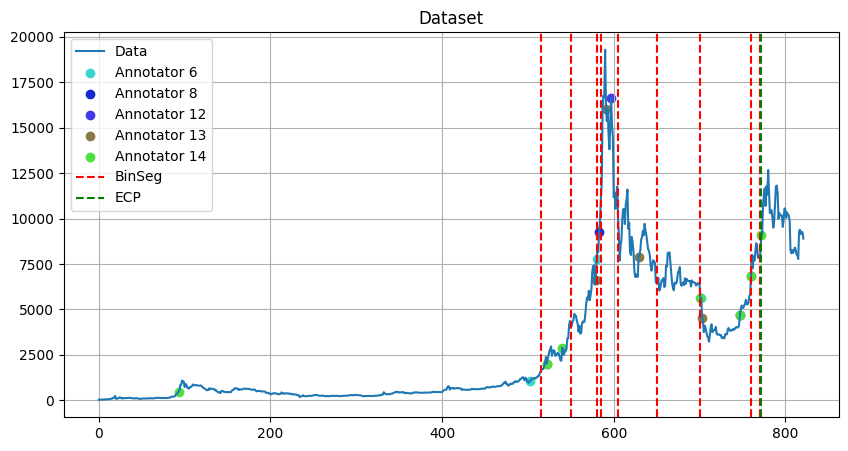

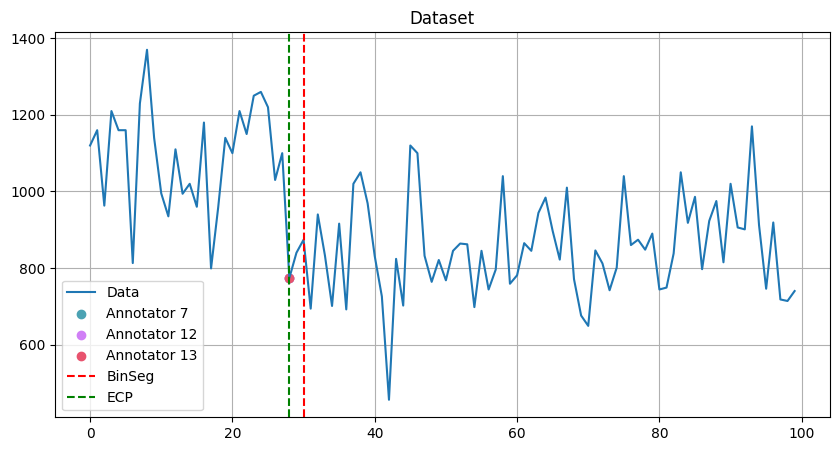

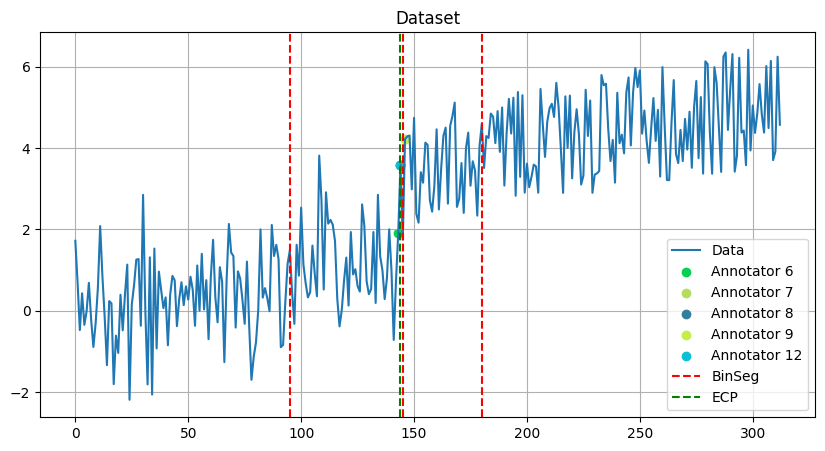

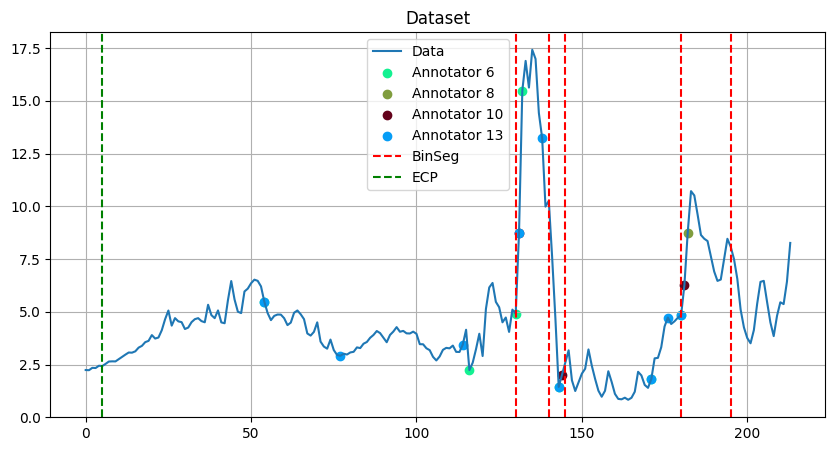

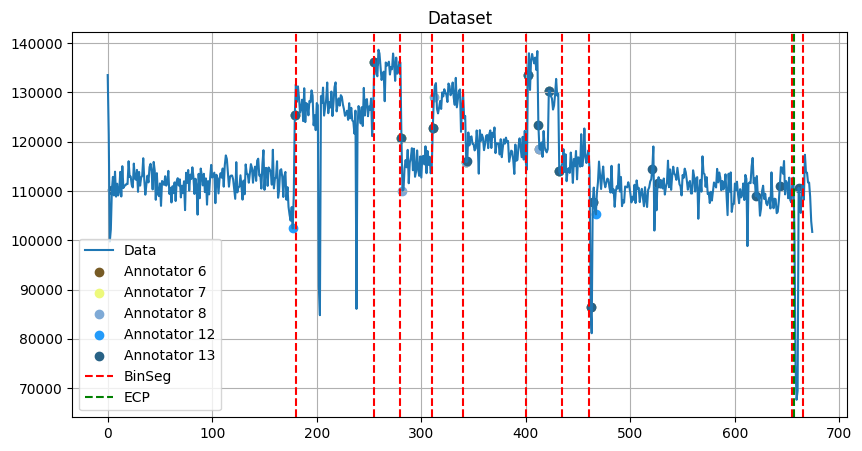

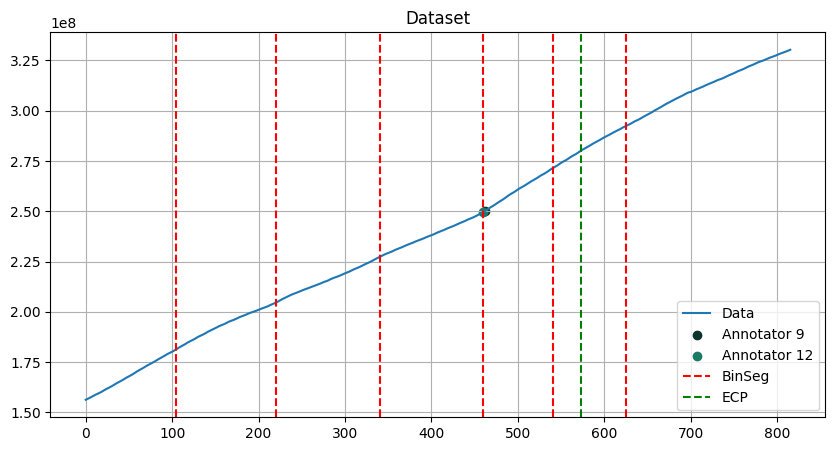

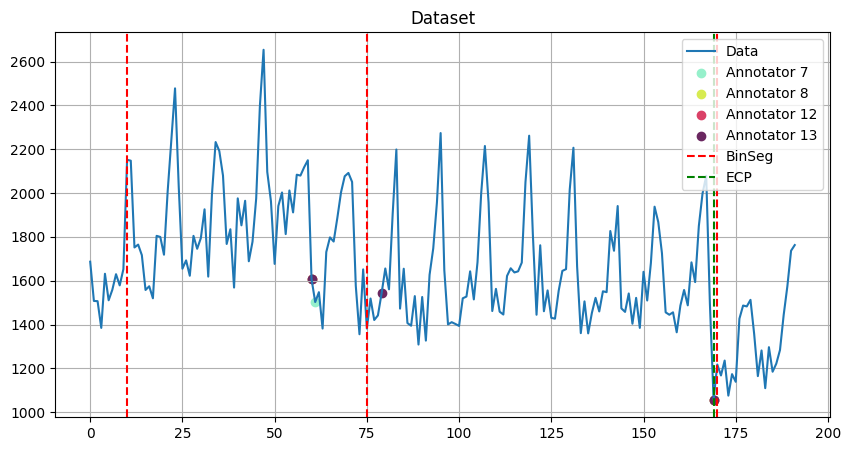

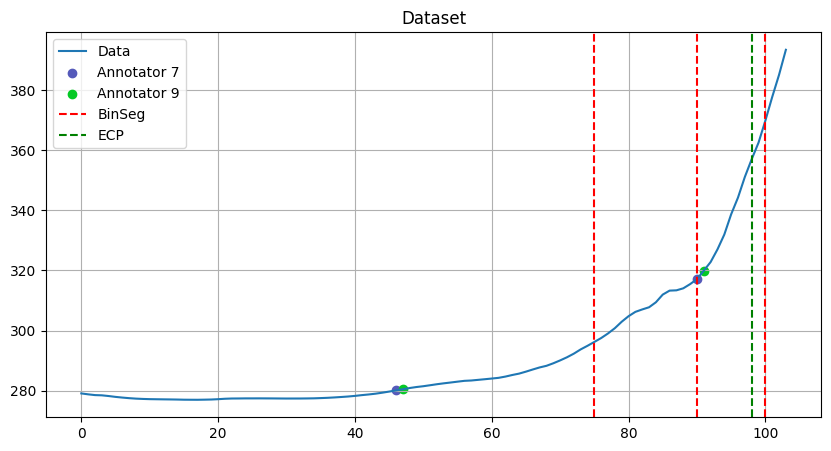

In [93]:
# the change points found by the algorithms vs the human annotations
def plot_change_points(data, annotations_dict, binseg_pred, ecp_pred):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(data, label="Data")
    ax.set_title("Dataset")
    ax.grid(True)

    # tracked added labels to prevent duplicates
    added_labels = set()

    for annotator, change_points in annotations_dict.items():
        color = np.random.rand(3,)
        label = f"Annotator {annotator}"
        for i, change_point in enumerate(change_points):
            if label not in added_labels:
                ax.scatter(change_point, data[change_point], c=[color], label=label)
                added_labels.add(label)
            else:
                ax.scatter(change_point, data[change_point], c=[color])

    if binseg_pred:
        ax.axvline(binseg_pred[0], color="red", linestyle="--", label="BinSeg")
        for cp in binseg_pred[1:]:
            ax.axvline(cp, color="red", linestyle="--")

    if ecp_pred:
        ax.axvline(ecp_pred[0], color="green", linestyle="--", label="ECP")
        for cp in ecp_pred[1:]:
            ax.axvline(cp, color="green", linestyle="--")

    ax.legend()
    plt.show()


plot_change_points(bitcoin_data, annotations["bitcoin"], binseg_pred_bitcoin, ecp_pred_bitcoin)
plot_change_points(nile_data, annotations["nile"], binseg_pred_nile, ecp_pred_nile)
plot_change_points(qc1_data, annotations["quality_control_1"], binseg_pred_qc1, ecp_pred_qc1)
plot_change_points(unemployment_nl_data, annotations["unemployment_nl"], binseg_pred_unemployment_nl, ecp_pred_unemployment_nl)
plot_change_points(well_log_data, annotations["well_log"], binseg_pred_well_log, ecp_pred_well_log)
plot_change_points(us_population_data, annotations["us_population"], binseg_pred_us_population, ecp_pred_us_population)
plot_change_points(seatbelts_data, annotations["seatbelts"], binseg_pred_seatbelts, ecp_pred_seatbelts)
plot_change_points(global_co2_data, annotations["global_co2"], binseg_pred_global_co2, ecp_pred_global_co2)
